In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.train_utils import *
from utils.dataset_utils import *
import tensorflow as tf
from matplotlib import pyplot as plt
from utils.config import *

2025-06-01 08:40:04.413939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748767204.594866      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748767204.645978      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
params = load_params()

IMAGE_SIZE = params['image_size']
BATCH_SIZE = params['batch_size']
CHANNELS = params['channels']
EPOCHS = params['epochs']
LR = params['learning_rate']
TRAIN_SPLIT = params['train_split']
VAL_SPLIT = params['val_split']
TEST_SPLIT = params['test_split']
EARLY_STOPPING_PATIENCE = params['early_stopping_patience']
REDUCE_LR_FACTOR = params['reduce_lr_factor']
REDUCE_LR_PATIENCE = params['reduce_lr_patience']
MIN_LR = params['min_lr']

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '../PlantVillage',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 16011 files belonging to 10 classes.


I0000 00:00:1748767238.932100      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
CLASS_NAMES=[name.replace('Tomato_', '').lstrip('_') for name in dataset.class_names]
print(CLASS_NAMES)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites_Two_spotted_spider_mite', 'Target_Spot', 'YellowLeaf__Curl_Virus', 'mosaic_virus', 'healthy']


In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset,TRAIN_SPLIT,VAL_SPLIT,TEST_SPLIT)

Full dataset length =  501
train dataset length =  400
validation dataset length =  50
test dataset length =  51


In [ ]:
train_ds=preprocess_dataset(train_ds)
val_ds=preprocess_dataset(val_ds)

In [13]:
class_weights = get_or_compute_class_weights(train_ds)
print(class_weights)

Class weights not found. Computing from dataset...
Class weights saved to class_weights.json
{5: 0.9674981103552532, 7: 0.5025520219866509, 3: 1.6819973718791064, 6: 1.1398040961709706, 4: 0.9123307198859587, 2: 0.8290155440414507, 0: 0.7403123192596877, 9: 1.0047095761381475, 8: 4.25249169435216, 1: 1.610062893081761}


In [16]:
model=build_model(IMAGE_SIZE,CLASS_NAMES,BATCH_SIZE,CHANNELS)
compile_model(model,LR)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 14, 14, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 6, 6, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 4608)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 256)                   │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,234 (5.57 MB)

 Trainable params: 1,460,234 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callbacks=get_callbacks(EARLY_STOPPING_PATIENCE,REDUCE_LR_FACTOR,REDUCE_LR_PATIENCE,MIN_LR)

In [ ]:
history=train_model(model,EPOCHS, train_ds,val_ds,callbacks,class_weights)

Epoch 1/70


E0000 00:00:1748767341.036071      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748767342.422334     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2369 - loss: 2.1258
Epoch 1: val_loss improved from inf to 1.74189, saving model to checkpoints/best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.2372 - loss: 2.1252 - val_accuracy: 0.4406 - val_loss: 1.7419 - learning_rate: 0.0010
Epoch 2/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6046 - loss: 1.1751
Epoch 2: val_loss did not improve from 1.74189
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6047 - loss: 1.1748 - val_accuracy: 0.4387 - val_loss: 2.0118 - learning_rate: 0.0010
Epoch 3/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7208 - loss: 0.8139
Epoch 3: val_loss improved from 1.74189 to 1.24310, saving model to checkpoints/best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7208 - loss: 0.8139 - val_accuracy: 0.6044 - val_loss: 1.2431 - learning_rate: 0.0010
Epoch 4/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7725 - loss: 0.66

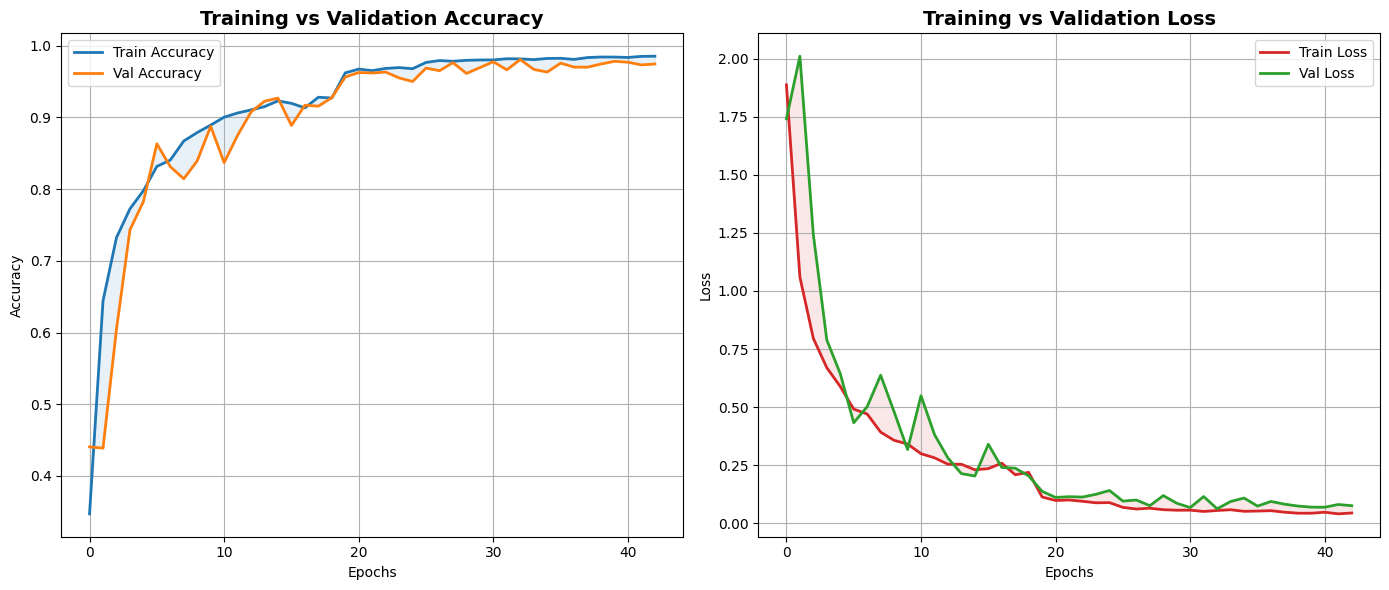

In [12]:
plot_metrics('../logs/training_log.csv','../plots')

## Test model on test dataset

First image to predict
Actual label:  Spider_mites_Two_spotted_spider_mite
Predicted label:  Spider_mites_Two_spotted_spider_mite


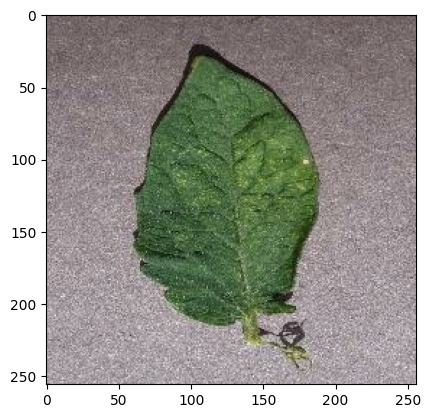

In [13]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ",CLASS_NAMES[first_label])
    batch_prediction=model.predict(images_batch,verbose=0)
    print("Predicted label: ",CLASS_NAMES[tf.math.argmax(batch_prediction[0])])

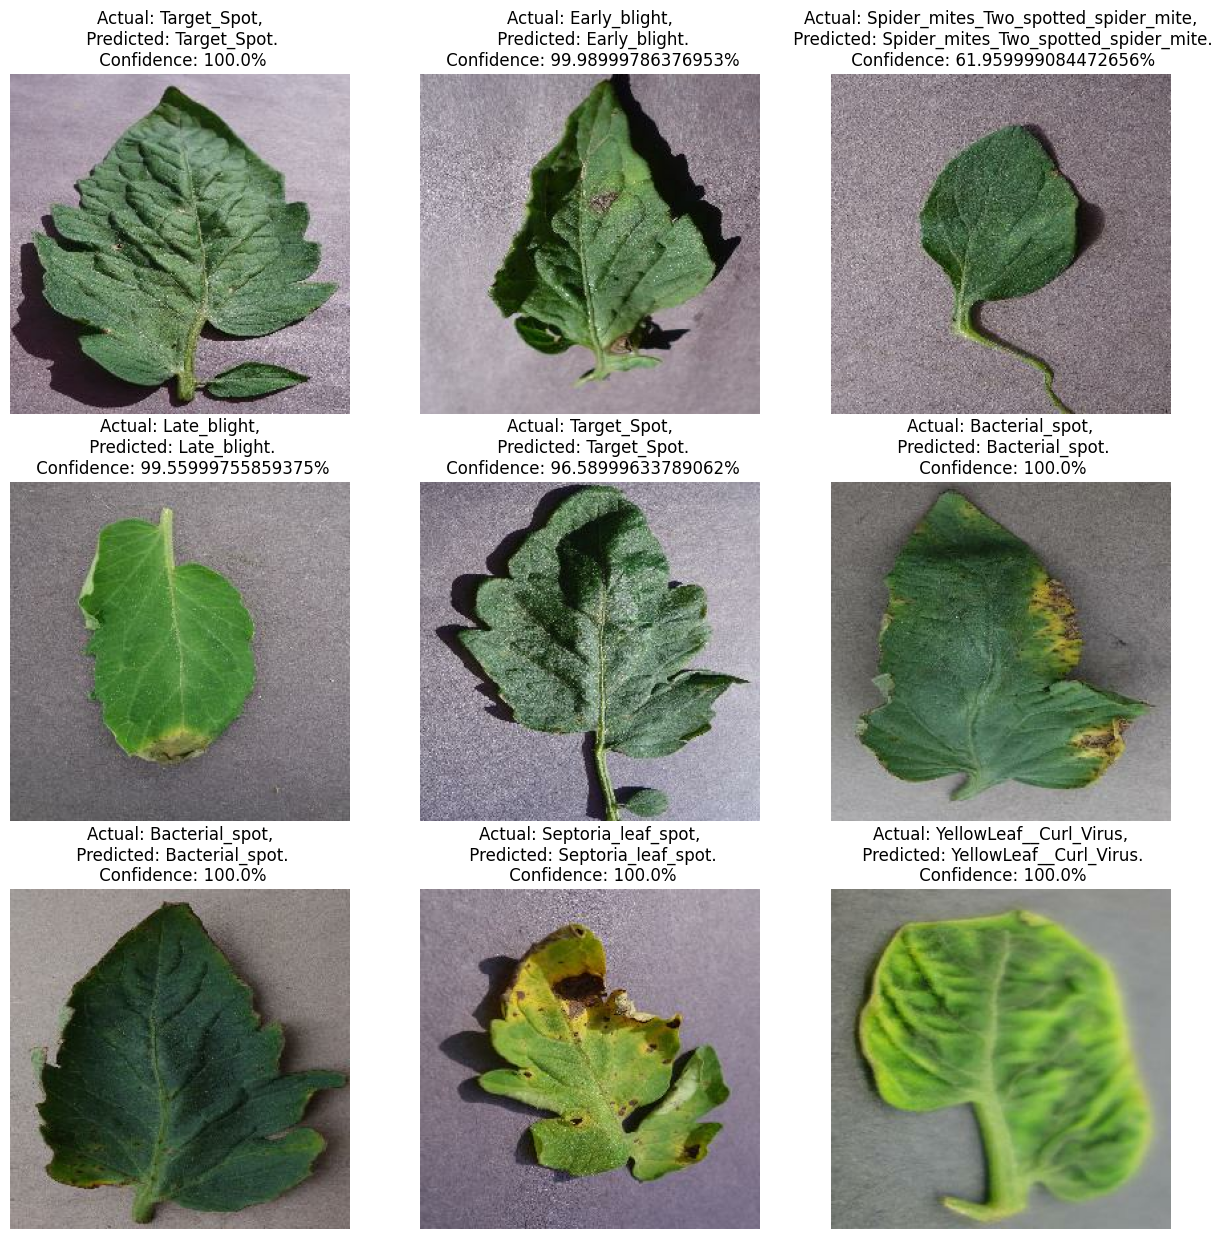

In [14]:
plt.figure(figsize=(15,15))
for images_batch,labels_batch in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        predicted_class,confidence=predict_image(model,images_batch[i].numpy(),CLASS_NAMES)
        actual_class=CLASS_NAMES[labels_batch[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.savefig(os.path.join('../plots', "model_predictions.png"))

In [15]:
test_loss,test_accuracy=model.evaluate(test_ds,verbose=0)
print(f'test loss: {test_loss:.4f}')
print(f'test accuracy: {test_accuracy*100:.4f} %')

test loss: 0.0409
test accuracy: 98.5102 %


In [22]:
from pathlib import Path

saved_model_dir = Path('../../saved_models')
saved_model_dir.mkdir(exist_ok=True)

# Find next version
MODEL_VERSION = max([int(p.name[1:]) for p in saved_model_dir.glob("v*") if p.name[1:].isdigit()] + [0]) + 1
model_path_save = saved_model_dir / f"tomato_model-v{MODEL_VERSION}.keras"     # Keras format
model_path_export = saved_model_dir / f"v{MODEL_VERSION}"                      # SavedModel format
model_path_export.mkdir(exist_ok=True)

# Save in both formats
model.save(model_path_save)            # .keras file
model.export(model_path_export)          # TensorFlow SavedModel format

print(f"Model saved as: {model_path_save}")
print(f"Exported SavedModel format to: {model_path_export}")

INFO:tensorflow:Assets written to: ..\..\saved_models\v1\assets


INFO:tensorflow:Assets written to: ..\..\saved_models\v1\assets


Saved artifact at '..\..\saved_models\v1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2439795655776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439795686736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794001872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794000816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794096080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794095024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794151088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794195088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794257056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794256176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439794417328: TensorSpec(sha

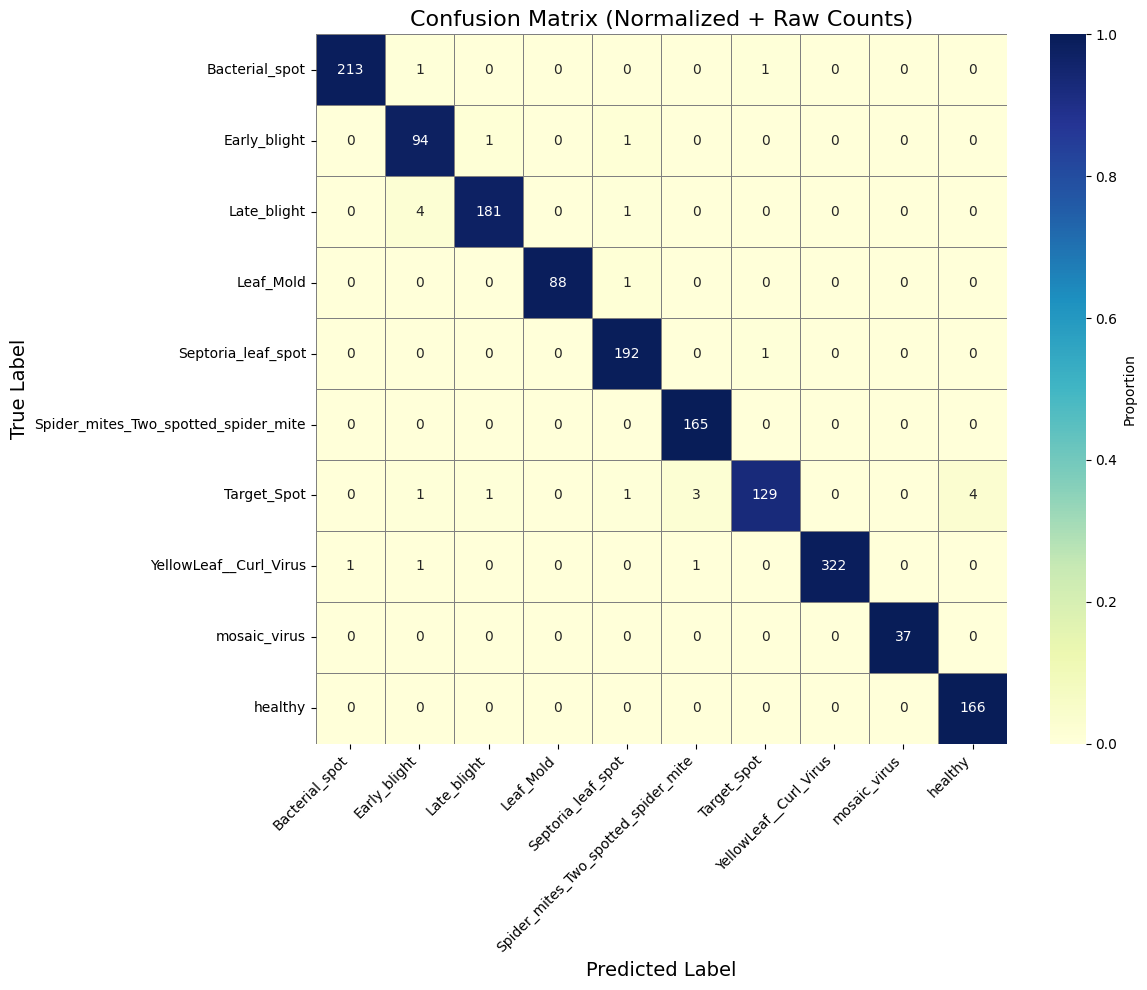

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(tf.math.argmax(preds, axis=1).numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm_normalized, annot=cm, fmt='d', cmap="YlGnBu",
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
    linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'}
)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix (Normalized + Raw Counts)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
os.makedirs("../plots", exist_ok=True)
plt.savefig("../plots/confusion_matrix.png", dpi=300)
plt.show()

<Figure size 1400x600 with 0 Axes>

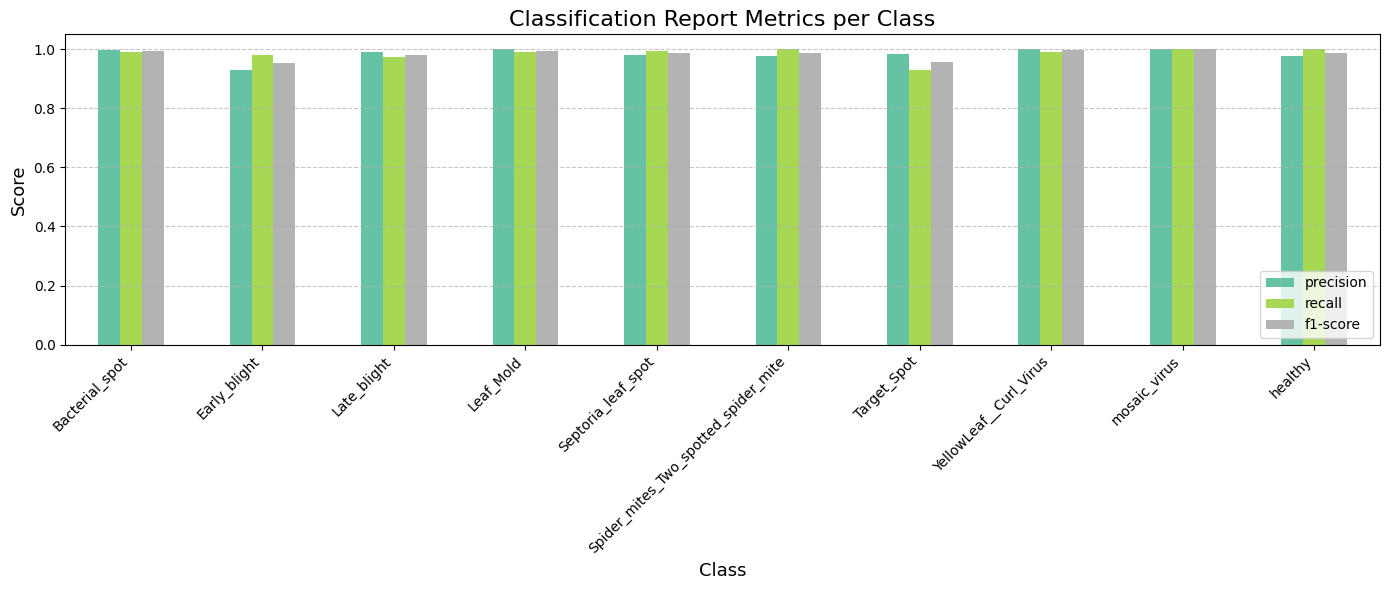

In [18]:
from sklearn.metrics import classification_report

# Get classification report as dict
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Drop overall averages
report_df = report_df.iloc[:-3, :]

# Plot
plt.figure(figsize=(14, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(14, 6), colormap="Set2")

plt.title("Classification Report Metrics per Class", fontsize=16)
plt.xlabel("Class", fontsize=13)
plt.ylabel("Score", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()

# Save it
os.makedirs("../plots", exist_ok=True)
plt.savefig("../plots/classification_report.png", dpi=300)
plt.show()

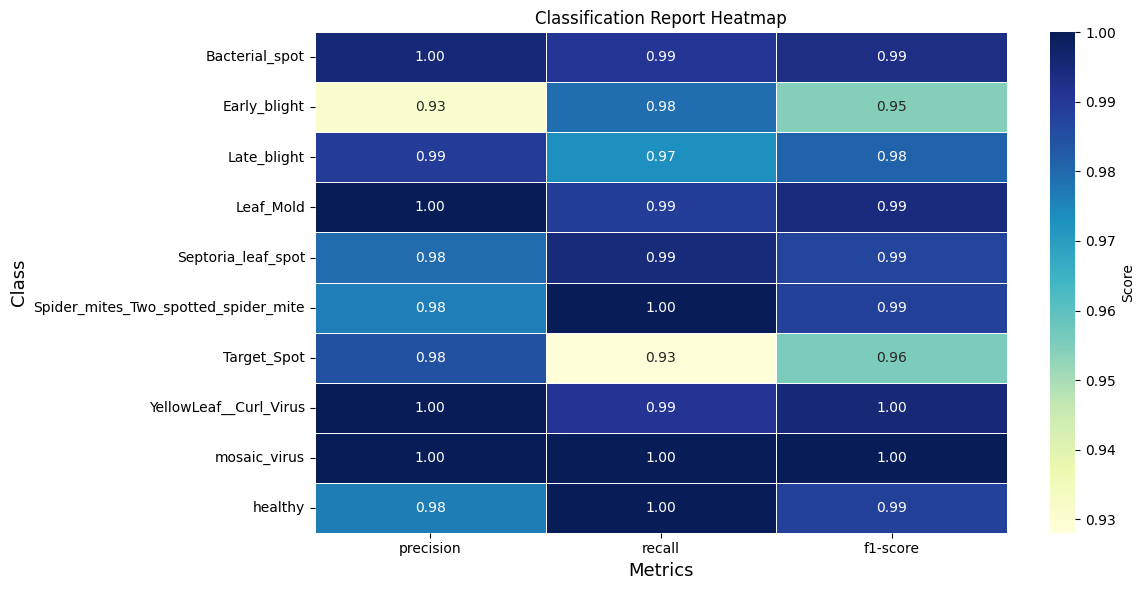

In [19]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Remove overall summary rows for better heatmap focus
metrics_df = report_df.iloc[:-3, :3]  # precision, recall, f1-score

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={"label": "Score"})

plt.title("Classification Report Heatmap")
plt.xlabel("Metrics", fontsize=13)
plt.ylabel("Class", fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

# Save plot
os.makedirs("../plots", exist_ok=True)
plt.savefig("../plots/classification_report_heatmap.png", dpi=300)
plt.show()

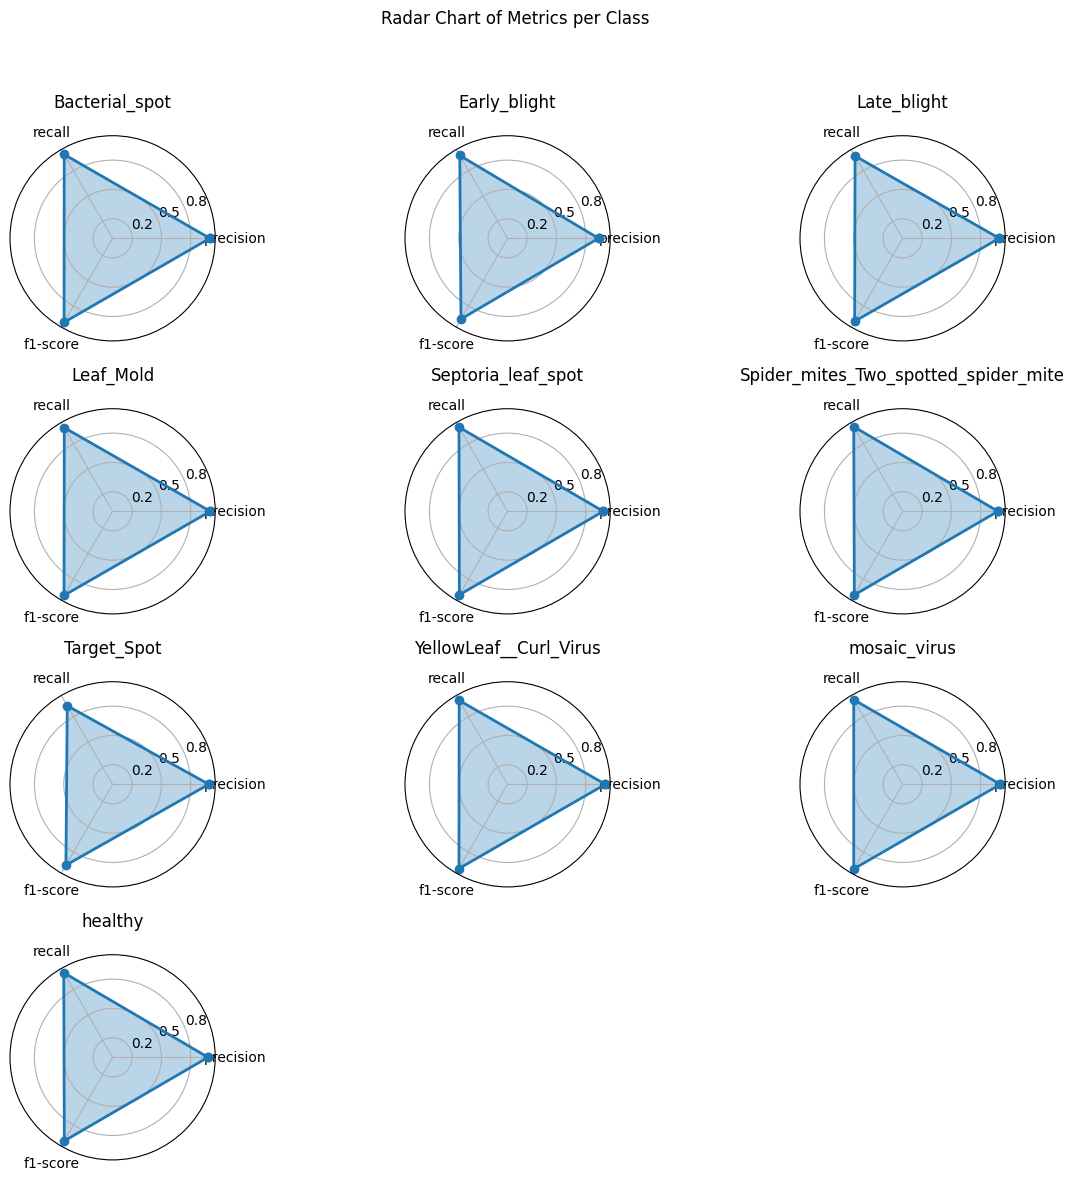

In [20]:
labels = ['precision', 'recall', 'f1-score']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

plt.figure(figsize=(12, 12))
for i, class_name in enumerate(CLASS_NAMES):
    values = [report[class_name][m] for m in labels]
    values += values[:1]
    angle_vals = angles + angles[:1]

    ax = plt.subplot(4, 3, i+1, polar=True)
    ax.plot(angle_vals, values, marker='o', linewidth=2)
    ax.fill(angle_vals, values, alpha=0.3)
    ax.set_title(class_name, y=1.1)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(angles)
    ax.set_xticklabels(labels)
    ax.set_yticks([0.2, 0.5, 0.8])
    ax.set_yticklabels(["0.2", "0.5", "0.8"])

plt.suptitle("Radar Chart of Metrics per Class")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../plots/classification_radar_per_class.png", dpi=300)
plt.show()

In [21]:
from pathlib import Path

saved_model_dir = Path('../../saved_models')

# Get all model files with the versioned pattern
model_files = sorted(saved_model_dir.glob("tomato_model-v*.keras"))

# Make sure at least one model exists
if not model_files:
    raise FileNotFoundError("No versioned model found in saved_models directory.")

# Get the latest version by parsing version numbers
latest_model_file = max(model_files, key=lambda p: int(p.stem.split("-v")[-1]))

# Load the latest model
model = tf.keras.models.load_model(latest_model_file)
print(f"Loaded model: {latest_model_file.name}")


Loaded model: tomato_model-v2.keras
